In [28]:
import numpy as np
import pandas as pd

# seed set for reproducible results  

In [29]:
np.random.seed(123) 

# importing modelling packages

In [30]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import math

# importing visualisation packages

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# importing data

In [32]:
train = pd.read_csv("Train_Data.csv")
test= pd.read_csv('Test_Data.csv')

In [33]:
train.head(5)

,date,campaign,adgroup,ad,impressions,clicks,cost,conversions,revenue
0,01-08-2020,campaign 1,adgroup 1,ad 1,24,6,0.08,0,0.00
1,01-08-2020,campaign 1,adgroup 2,ad 1,1,0,0.00,0,0.00
2,01-08-2020,campaign 1,adgroup 3,ad 1,13,4,0.04,0,0.00
3,01-08-2020,campaign 1,adgroup 4,ad 1,5,4,0.08,0,0.00
4,01-08-2020,campaign 1,adgroup 1,ad 2,247,126,1.29,4,925.71


In [34]:
train.shape

(4571, 9)

# DATA VISUALIZATION
## revenue plot shows there are several spikes and there is no linearity in the data

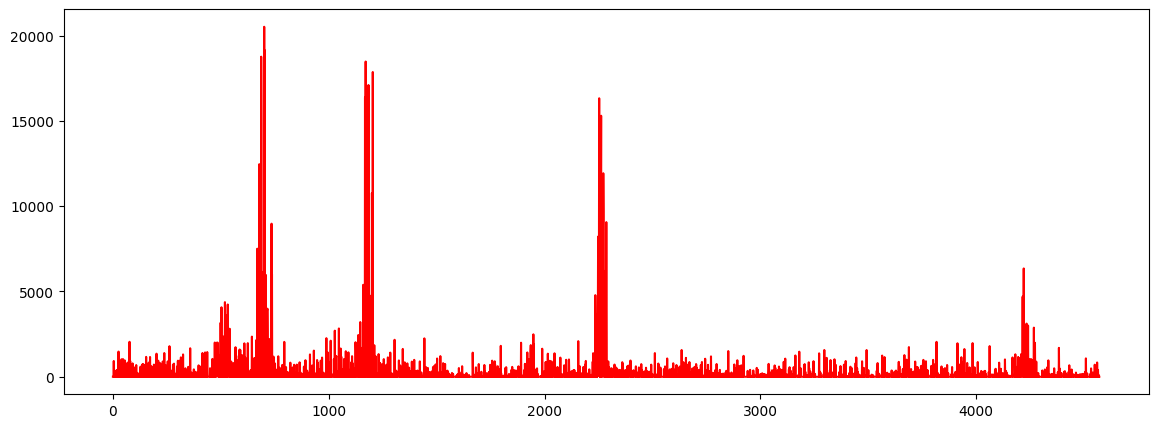

In [35]:
plt.figure(figsize=(14,5))
plt.tight_layout()
plt.plot(train['revenue'],color='red')

# correlation matrix - impressions and clicks are highly correlated
### conversions would be an important predictor

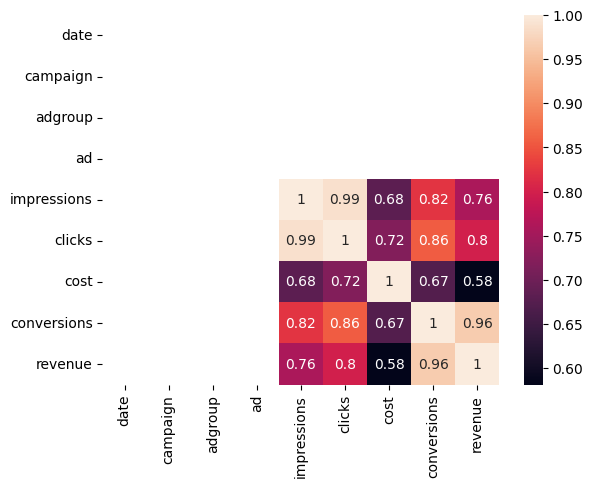

In [36]:
train_numeric = train.apply(pd.to_numeric, errors='coerce')

# Create a correlation matrix and plot heatmap
ax = sns.heatmap(train_numeric.corr(), annot=True)

# Display the plot
plt.show()


# Mean revenue distribution as per adgroups - adgroup 1 and 3 are prominent

<Axes: xlabel='adgroup'>

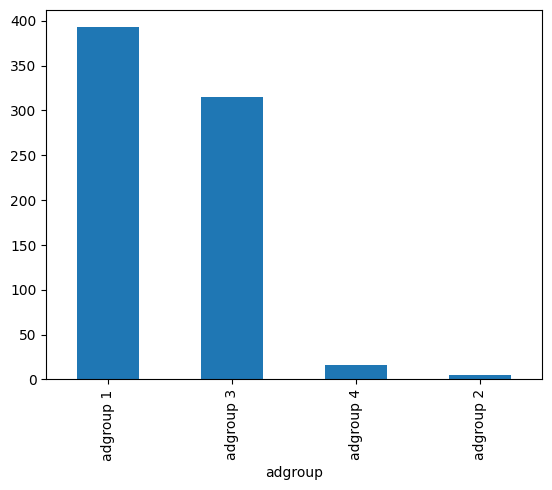

In [37]:
# Convert 'revenue' column to numeric if possible
train['revenue'] = pd.to_numeric(train['revenue'], errors='coerce')

# Plot the mean of 'revenue' by 'adgroup'
train.groupby('adgroup')['revenue'].mean().sort_values(ascending=False).plot(kind='bar')


# most frequent ads - ads 3,1,2,7,32 and 10 are prominent

<Axes: xlabel='ad'>

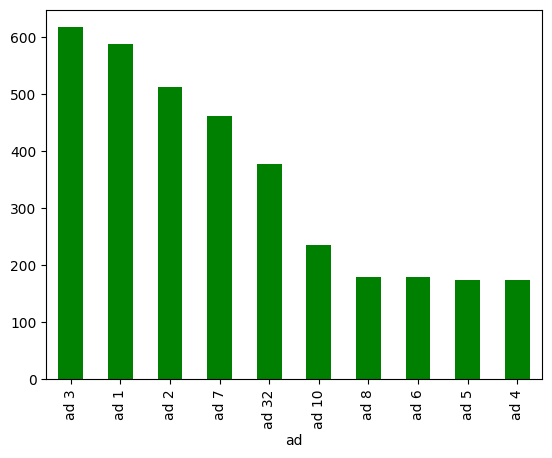

In [38]:
train.groupby('ad').count()['revenue'].sort_values(ascending=False)[0:10].plot(kind='bar',color='green')



# Quick EDA using describe method - to see if there are any missing values and get an idea of deviation of variables


In [39]:
train.describe()

,impressions,clicks,cost,conversions,revenue
count,4571.000000,4571.000000,4571.000000,4571.000000,4571.000000
mean,92.635747,43.340844,2.800834,1.339094,231.865340
std,198.349737,100.164913,14.361618,5.223922,1091.742763
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,2.000000,0.040000,0.000000,0.000000
50%,16.000000,7.000000,0.210000,0.000000,0.000000
75%,84.000000,38.000000,1.350000,1.000000,92.600000
max,3239.000000,1771.000000,531.250000,94.000000,20515.410000


# separating date into day and year 
### - had tried all day,month,year combinations - day and year best combination


In [40]:
train['day']=pd.to_numeric(train['date'].apply(lambda x:x.split("-")[0]))
train['year']=pd.to_numeric(train['date'].apply(lambda x:x.split("-")[2]))

test['day']=pd.to_numeric(test['date'].apply(lambda x:x.split("-")[0]))
test['year']=pd.to_numeric(test['date'].apply(lambda x:x.split("-")[2]))


In [41]:
#revenue variable transformation - logged to take care of spikes (~3200 zeroes)

train.loc[train['revenue']==0,'revenue']=0.001
train['revenue']=np.log(train['revenue'])

# dropping date and campaign variables

train.drop(['date','campaign'],axis=1,inplace=True)
test.drop(['date','campaign'],axis=1,inplace=True)



In [42]:
# feature engineering - had to drop clicks and impressions as highly correlated (kept CTR to capture info.)
# had created CPC as well, but reduced model's accuracy. Best combo is CTR and CPA

train['CTR']=train['clicks']/train['impressions']
train['CPA']=train['cost']/train['conversions']
train.drop(['clicks','impressions'],axis=1,inplace=True)

test['CTR']=test['clicks']/test['impressions']
test['CPA']=test['cost']/test['conversions']
test.drop(['clicks','impressions'],axis=1,inplace=True)

# treating nan and inf of CPA - replacing inf with nan and then nan with mean

train['CPA'] = train['CPA'].replace(np.inf, np.nan)
train['CPA'] = train['CPA'].replace(np.nan, train['CPA'].mean()) 

test['CPA'] = test['CPA'].replace(np.inf, np.nan)
test['CPA'] = test['CPA'].replace(np.nan, test['CPA'].mean())

In [43]:
# converting categorical features into integer features
# with the most common category of the feature being converted to integer 0,the next most common to 1, and so on
# day,ad,adgroup,year encoded as per frequenct as they had levels whose counts varied as per revenue made

def freqencoder(data, col):
        df = data
        val_freq = df[col].value_counts()
        df[col] = [val_freq.index.tolist().index(i) for i in df[col]]
        return df

train = freqencoder(train,'adgroup')
train = freqencoder(train,'ad')
train = freqencoder(train,'day')
train = freqencoder(train,'year')

test = freqencoder(test,'adgroup')
test = freqencoder(test,'ad')
test = freqencoder(test,'day')
test = freqencoder(test,'year')

# converting all features to float

train=train.astype(float)
test=test.astype(float)


In [44]:
X= train.drop('revenue',axis=1)
Y= train['revenue']
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.3)

In [45]:
X_train.head(5)

,adgroup,ad,cost,conversions,day,year,CTR,CPA
2546,2.0,5.0,0.00,0.0,8.0,0.0,0.000000,1.873793
732,3.0,46.0,0.01,0.0,27.0,0.0,1.000000,1.873793
3558,0.0,11.0,0.49,0.0,21.0,1.0,0.583333,1.873793
1729,2.0,1.0,0.59,1.0,1.0,0.0,0.333333,0.590000
618,0.0,0.0,4.61,0.0,15.0,0.0,0.520468,1.873793


### Checking Null Values

In [46]:
X_train.isnull().any()

adgroup        False
ad             False
cost           False
conversions    False
day            False
year           False
CTR            False
CPA            False
dtype: bool

In [47]:
y_train.isnull().any()
print(y_train.value_counts())

revenue
-6.907755    2254
 3.951244       6
 3.988984       5
 5.225747       5
 5.135798       4
             ... 
 5.383531       1
 4.882802       1
 5.247813       1
 6.853542       1
 5.649080       1
Name: count, Length: 872, dtype: int64


In [48]:
X_test.isnull().any()

adgroup        False
ad             False
cost           False
conversions    False
day            False
year           False
CTR            False
CPA            False
dtype: bool

In [49]:
y_test.isnull().any()
print(y_test.value_counts())

revenue
-6.907755    962
 4.174387      4
 4.736198      3
 3.988984      3
 4.060443      2
            ... 
 6.611207      1
 5.132617      1
 6.303187      1
 5.451038      1
 6.455670      1
Name: count, Length: 387, dtype: int64


# Random Forest Model

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model1 = RandomForestRegressor(random_state=1)
model1.fit(X_train_scaled,y_train)
ans1 = model1.predict(X_test_scaled)

In [51]:
from sklearn.metrics import mean_squared_error
print("Mean Squared Error: " + str(mean_squared_error(ans1, y_test,squared =False)))

Mean Squared Error: 0.48115840704512963


# XG Boost Model

In [52]:
from xgboost import XGBRegressor
model2 = XGBRegressor(base_score=0.8, booster='gbtree', colsample_bylevel=1,
           colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
           importance_type='gain', interaction_constraints='',
           learning_rate=0.235, max_delta_step=0, max_depth=6,
           min_child_weight=1, monotone_constraints='()',
             n_estimators=10000, n_jobs=5, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1)
model2.fit(X_train, y_train, 
             early_stopping_rounds=6, 
             eval_set=[(X_test, y_test)], 
             verbose=False)



C:\Users\ishika\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBRegressor(base_score=0.8, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy=None, importance_type='gain',
             interaction_constraints='', learning_rate=0.235, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=0,
             max_depth=6, max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=5,
             num_parallel_tree=1, predictor=None, random_state=0, ...)

In [53]:
from sklearn.metrics import mean_squared_error
predictions = model2.predict(X_test)
print("Mean Squared Error: " + str(mean_squared_error(predictions, y_test,squared =False)))


Mean Squared Error: 0.4645959500169664


In [54]:
submission= model2.predict(test)
submission=pd.Series(submission)
submission=pd.DataFrame(submission, columns = ["revenue"])
submission.to_csv('Submission.csv',index=False)